In [1]:
#!pip install tensorflow

In [2]:
# Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

C:\Users\Olga Lucia\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
#Se cargan los datos del repositorio
url = "https://raw.githubusercontent.com/jetabaresj/DespliegueTeam23/refs/heads/main/data/heart_failure_clinical_records_dataset.csv"
df = pd.read_csv(url)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
#Se divide el DF en entranamiento y prueba
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#Se escalan los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# 1. Modelo de Regresión Logística
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
log_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])
log_fpr, log_tpr, log_thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])

In [6]:
# 2. Modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

In [7]:
# 3. Modelo Gradient Boosting
gbc_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbc_model.fit(X_train, y_train)
y_pred_gbc = gbc_model.predict(X_test)
gbc_auc = roc_auc_score(y_test, gbc_model.predict_proba(X_test)[:, 1])
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_test, gbc_model.predict_proba(X_test)[:, 1])


In [8]:
# 4. Red Neuronal
nn_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=0)
nn_loss, nn_accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
nn_auc = roc_auc_score(y_test, nn_model.predict(X_test))
nn_fpr, nn_tpr, nn_thresholds = roc_curve(y_test, nn_model.predict(X_test))


3/3 [==============================] - 0s 7ms/step


Se escoge el modelo de regresión logística por tener un accuracy más alto

In [9]:
# 5. Modelo XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])


In [10]:
# Crear DataFrame con métricas de rendimiento
metrics_df = pd.DataFrame({
    'Model': ['Regresión Logística', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'Red Neuronal'],
    'Accuracy': [accuracy_score(y_test, y_pred_log), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_gbc), accuracy_score(y_test, y_pred_xgb), nn_accuracy],
    'AUC': [log_auc, rf_auc, gbc_auc, xgb_auc, nn_auc]
})

print("Comparación de Modelos - Accuracy y AUC")
print(metrics_df)

Comparación de Modelos - Accuracy y AUC
                 Model  Accuracy       AUC
0  Regresión Logística  0.773333  0.813783
1        Random Forest  0.733333  0.838343
2    Gradient Boosting  0.720000  0.854106
3              XGBoost  0.773333  0.870235
4         Red Neuronal  0.653333  0.779326


In [11]:
# Crear DataFrame para la tabla ROC de cada modelo
roc_table = {
    'Model': ['Logistic Regression'] * len(log_fpr) + ['Random Forest'] * len(rf_fpr) +
             ['Gradient Boosting'] * len(gbc_fpr) + ['XGBoost'] * len(xgb_fpr) + ['Neural Network'] * len(nn_fpr),
    'FPR': np.concatenate([log_fpr, rf_fpr, gbc_fpr, xgb_fpr, nn_fpr]),
    'TPR': np.concatenate([log_tpr, rf_tpr, gbc_tpr, xgb_tpr, nn_tpr]),
    'Threshold': np.concatenate([log_thresholds, rf_thresholds, gbc_thresholds, xgb_thresholds, nn_thresholds])
}
roc_df = pd.DataFrame(roc_table)
# Mostrar tabla ROC detallada
print("\nTabla Detallada de Curvas ROC")
print(roc_df.head(5)) 


Tabla Detallada de Curvas ROC
                 Model       FPR       TPR  Threshold
0  Logistic Regression  0.000000  0.000000        inf
1  Logistic Regression  0.000000  0.032258   0.999744
2  Logistic Regression  0.000000  0.225806   0.904620
3  Logistic Regression  0.022727  0.225806   0.877510
4  Logistic Regression  0.022727  0.290323   0.858361


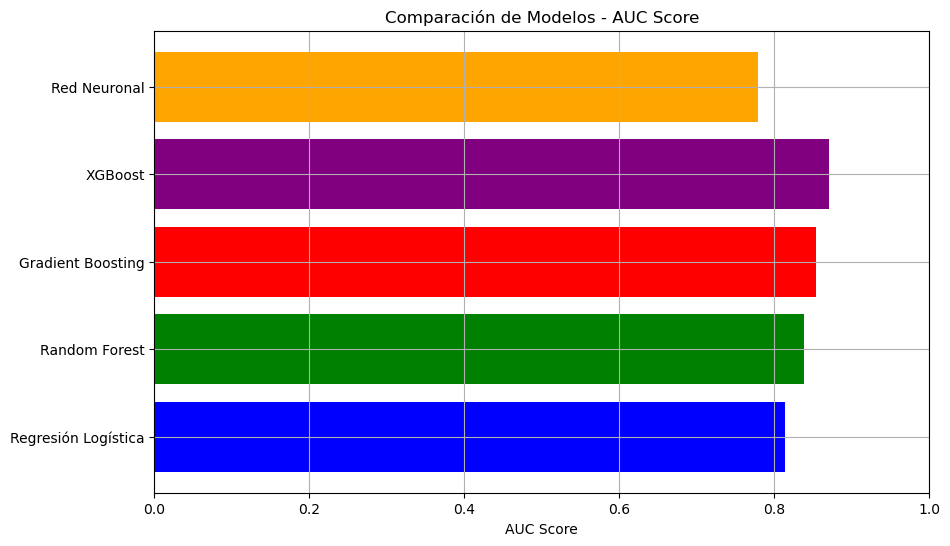

In [12]:
# Gráfico comparativo de AUC
plt.figure(figsize=(10, 6))
plt.barh(metrics_df['Model'], metrics_df['AUC'], color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('AUC Score')
plt.title('Comparación de Modelos - AUC Score')
plt.xlim(0, 1)
plt.grid(True)
plt.show()


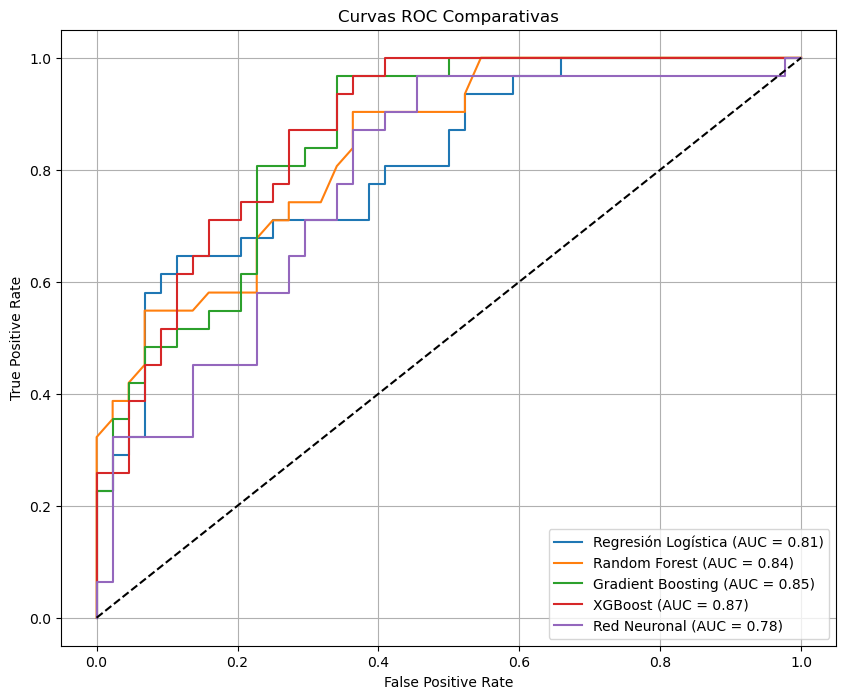

In [13]:
# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
plt.plot(log_fpr, log_tpr, label=f'Regresión Logística (AUC = {log_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(gbc_fpr, gbc_tpr, label=f'Gradient Boosting (AUC = {gbc_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot(nn_fpr, nn_tpr, label=f'Red Neuronal (AUC = {nn_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC Comparativas')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()